In [1]:
import mne
import os
import glob
import numpy as np
import pandas as pd
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import pickle

import sys
sys.path.append('../utils')
from pp_utils import *

In [2]:
#======================================================================================
#                        INITIALIZE DIRECTORIES
#======================================================================================
pp_dir = "/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed" #where the preprocessed files are

subjects_to_process = ['01']

In [3]:
#======================================================================================
#                        PARAMETERS
#======================================================================================
with open('../utils/ch_names.pkl', 'rb') as file:
    ch_names_all = pickle.load(file)
ch_names_64 = ch_names_all[0:64]

In [4]:
#======================================================================================
#                        PARAMETERS
#======================================================================================
for folder in sorted(os.listdir(pp_dir)):
    if folder not in subjects_to_process:
        continue
    sub_pp_dir = os.path.join(pp_dir, folder)
    data_path = glob.glob(os.path.join(sub_pp_dir, 'eeg_error_post_??.mat'))[0]

    subject_ID = data_path.split('.')[0][-2:]

    print('Opening', data_path.split('/')[-1])
    
    data = loadmat(data_path)
    eeg = data['trial_data']
    refs = data['trial_mastoids']
    events_sv = data['events']

    """  already_processed = []
    already_processed.append(subject_ID)"""


    

Opening eeg_error_post_01.mat


In [5]:
#making raw object from .mat data

info_raw = mne.create_info(ch_names=ch_names_64, sfreq = 128, ch_types='eeg')
raw = mne.io.RawArray(eeg, info = info_raw)
raw.set_montage('biosemi64')


Creating RawArray with float64 data, n_channels=64, n_times=76800
    Range : 0 ... 76799 =      0.000 ...   599.992 secs
Ready.


<RawArray | 64 x 76800 (600.0 s), ~37.6 MB, data loaded>

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 16.000 (s)


/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


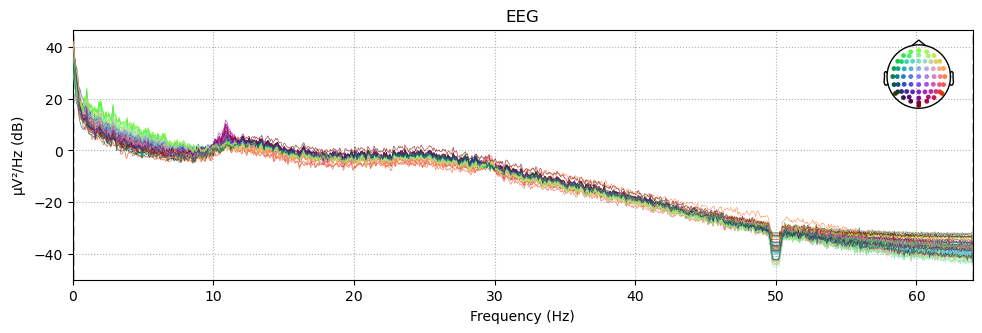

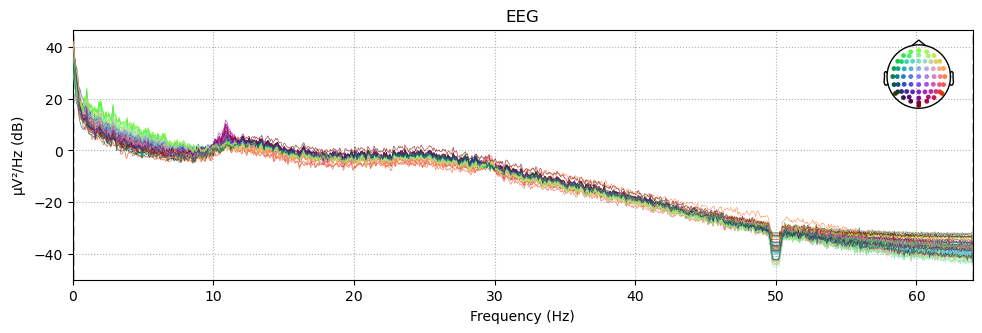

In [6]:
#check psd
mne.viz.plot_raw_psd(raw, fmin = 0, fmax = 64)

In [17]:
events_arr = make_raw_events(events_sv)
t_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])
t_inv = clean_triggers(events_arr[events_arr[:, 2]==3])
t_shinv = clean_triggers(events_arr[events_arr[:, 2]==4])
t_norm = clean_triggers(events_arr[events_arr[:, 2]==5])
t_modeswitch = clean_triggers(events_arr[(events_arr[:, 2]==3) | (events_arr[:, 2]==4) | (events_arr[:, 2]==5)])

In [8]:
epochs = mne.Epochs(raw, t_keystrokes, tmin=-0.3, tmax=0.7, preload=True)
fig = epochs.plot(events=t_keystrokes)

Not setting metadata
390 matching events found
Setting baseline interval to [-0.296875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 390 events and 129 original time points ...
0 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.
Using qt as 2D backend.
Using pyopengl with version 3.1.6


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


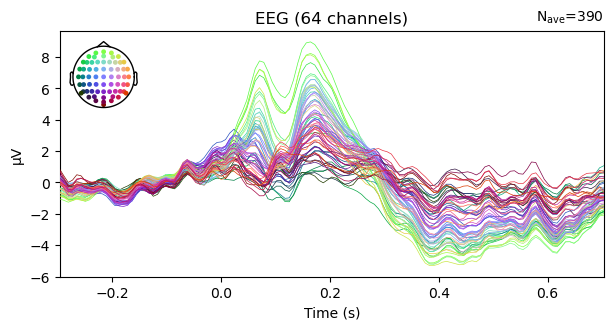

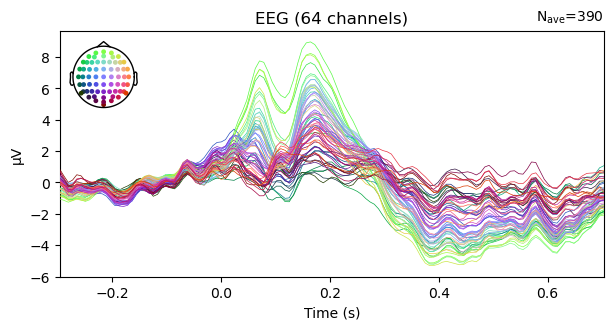

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [9]:
evoked = epochs.average()
evoked.plot(spatial_colors = True)

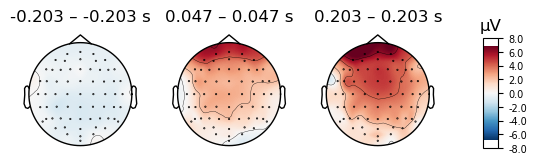

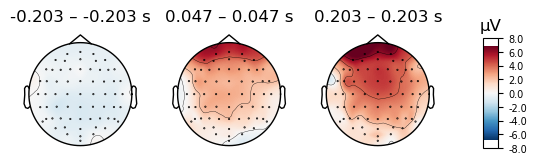

In [11]:
evoked.plot_topomap(times=[-0.2, 0.05, 0.2], average=0.005)

In [20]:
shinv_sections = find_sections(raw, t_shinv, t_modeswitch)
shinv_keystrokes = find_keystrokes(raw, t_keystrokes, shinv_sections)

Not setting metadata
133 matching events found
Setting baseline interval to [-0.296875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 133 events and 129 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


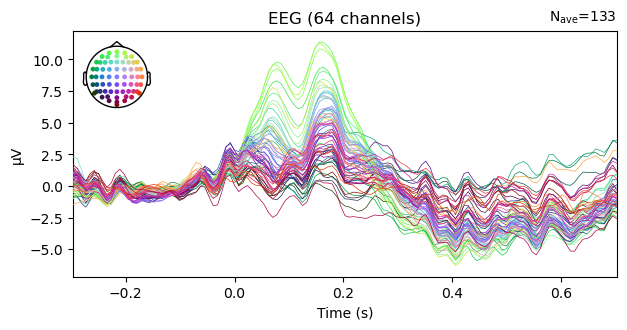

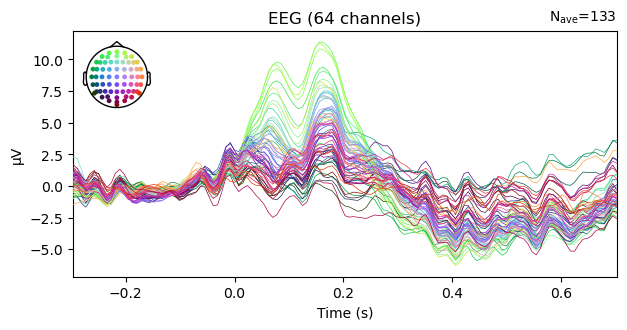

In [23]:
epochs_shinv = mne.Epochs(raw, shinv_keystrokes, tmin=-0.3, tmax=0.7, preload=True)
shinv_evoked = epochs_shinv.average()
shinv_evoked.plot()